# Project Part 1

In [173]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

## Part 1a

In [30]:
data1a = np.load('part1a.npz')

In [244]:
I_c0 = data1a['Ic_0']
N = data1a['N'].sum() - I_c0.sum()
S_0 = data1a['Svc_0_pmf'].flatten()*(N.reshape(1)[0]).flatten()
R_0 = np.array([0])
t = np.linspace(0,120,120)

initial_vec = np.concatenate([S_0,I_c0,R_0])
betas = np.linspace(0.01,1,16).reshape(4,4)
gamma = data1a['gamma'].reshape(1)[0]

### 1)

In [240]:
# SIR Model

def SIR_model(t, Y, betas, gamma):
    S_vector=Y[:16].reshape(4,4)
    I_vector=Y[16:20]
    R=Y[20]
    
    # (-(-(np.sum(betas, axis = 1)*np.sum(S_vector, axis = 1)*np.sum(I_vector)))
    
    dSvc_dt= (-(betas*S_vector*np.sum(I_vector))/N)
    dIc_dt= (-np.sum(dSvc_dt, axis = 1) - gamma*I_vector).flatten()
    dR_dt= gamma*np.sum(I_vector).flatten()
    
    RHS_vector= np.concatenate([dSvc_dt.flatten(), dIc_dt, dR_dt])

    return RHS_vector

In [241]:
# Solving the initial value problem

from scipy.integrate import solve_ivp

soln_obj = solve_ivp(SIR_model, (t[0],t[-1]), initial_vec, 
                     args = (betas, gamma), dense_output = True)

In [242]:
# Calculate L's
Lc = data1a['Lc'].reshape(4,1)

L = np.sum(soln_obj.sol(t)[16:20]*Lc, axis = 0)

### 2)

Here we plot all the $S_{v,c}$ and $I_c$ values over time.

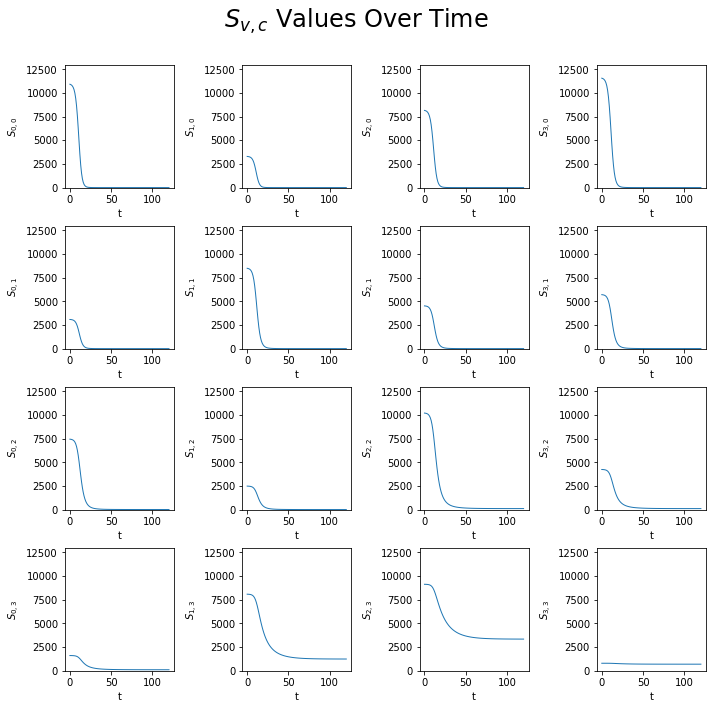

In [243]:
# S_v,c's
plt.figure(figsize=(10,10))

for i in range(0,16):
    
    plt.subplot(4,4, i+1)
    plt.ylim(-10, 13000)
    plt.plot(t, soln_obj.sol(t)[i], linewidth=1)
    plt.xlabel("t")
    plt.ylabel('$S_{{{},{}}}$'.format(i%4, i//4)).set_rotation(90)
    

plt.tight_layout()
plt.suptitle('$S_{v,c}$ Values Over Time', fontsize = 24)
plt.subplots_adjust(top=.90)
plt.show()


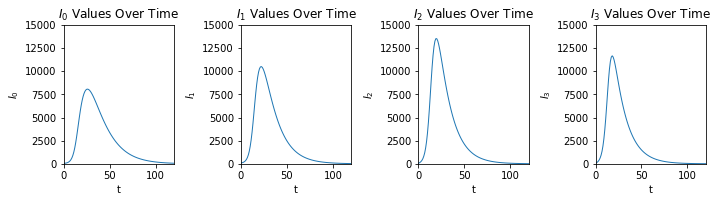

In [128]:
#I_c's over time

plt.figure(figsize=(10,10))

for i in range(0,4):
    
    plt.subplot(4,4, i+1)
    plt.xlim(0, 120)
    plt.ylim(0, 15000)
    plt.plot(t, soln_obj.sol(t)[i + 16], linewidth=1)
    plt.xlabel("t")
    plt.ylabel('$I_{}$'.format(i)).set_rotation(90)
    plt.title('$I_{}$ Values Over Time'.format(i))
    
#plt.suptitle('$I_{c}$ Values Over Time', fontsize = 20)
plt.subplots_adjust(top=.2)
plt.tight_layout()
plt.show()


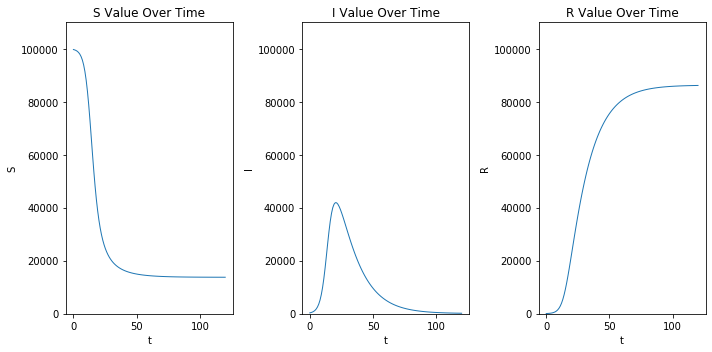

In [228]:
plt.figure(figsize=(10,5))

# S_v,c

plt.subplot(1,3,1)

plt.plot(t, np.sum(soln_obj.sol(t)[0:16], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("S")
plt.ylim(-100, 110000)
plt.title('S Value Over Time')


plt.subplot(1,3,2)

# I
plt.plot(t, np.sum(soln_obj.sol(t)[16:20], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("I")
plt.ylim(-100, 110000)
plt.title('I Value Over Time')


plt.subplot(1,3,3)

# R
plt.plot(t, soln_obj.sol(t)[-1], linewidth=1)
plt.xlabel("t")
plt.ylabel("R")
plt.ylim(-100, 110000)
plt.title('R Value Over Time')

plt.tight_layout()
plt.show()

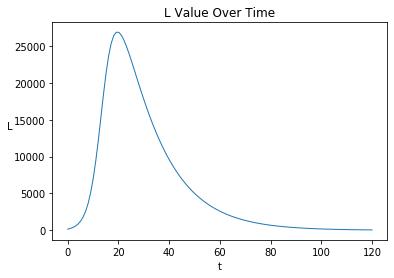

In [217]:
# L
plt.plot(t, L, linewidth=1)
plt.xlabel("t")
plt.ylabel("L").set_rotation(0)
plt.title('L Value Over Time')
plt.show()

### 3)

These plots do look like what we would expect. We would see the overall susceptible population start very close to *N*, and we would see this quickly decrease over time and then flatten out at the right tail. As *S* decreases, we would see the infected population, *I*, increase and then go back down and flatten out. As *I* increases, we would also see the viral load, *L*, increase and as *I* decreases, we would see *L* decrease. Finally, as time goes on and we see *I* go down, the number of people who have recovered, *R* would increase. The plot which is normally referred to as "flattening the curve" is the infected curve. By "flattening" the infected curve, we are able to slow the spread of the disease and prevent hospitals from being above their capacity.

### 4)

Some plots did converge to zero, while others converged to a positive value. I believe this is the case because $\beta_{v,c} = \frac{1}{Time\ between\ Contacts}$, which means that a smaller beta value would correspond to a longer time between contacts. If less people are in contact with eachother, then they are not spreading the disease as easily. This would explain why the first couple of $S_{v,c}$ plots show the curve converging to a constant. These first curves have smaller beta values while the later plots after have larger values. 

### 5)

The percentages of each population which did not get infected are below:

In [183]:
from IPython.display import display

non_infected = pd.DataFrame((soln_obj.sol(t)[0:16][:,-1]/S_0).reshape(4,4))

display(non_infected)

,0,1,2,3
0,0.886075,0.398826,0.179521,0.080811
1,0.036380,0.016380,0.007376,0.003322
2,0.001496,0.000674,0.000304,0.000137
3,0.000062,0.000028,0.000013,0.000006


### 6)

In [185]:
quarter_betas = (np.linspace(0.01,1,16).reshape(4,4))*.25

from scipy.integrate import solve_ivp

soln_obj_quart = solve_ivp(SIR_model, (t[0],t[-1]), initial_vec, 
                     args = (quarter_betas, gamma), dense_output = True)


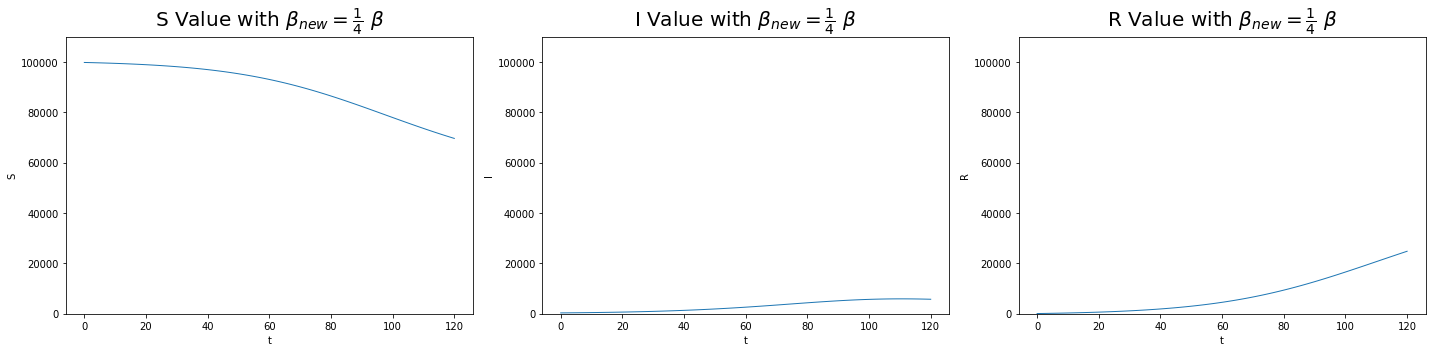

In [246]:
plt.figure(figsize=(20,5))

# S_v,c

plt.subplot(1,3,1)

plt.plot(t, np.sum(soln_obj_quart.sol(t)[0:16], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("S")
plt.ylim(-100, 110000)

plt.title('S Value with $ \\beta_{new} = \\frac{1}{4}\ \\beta$', fontsize = 20)


plt.subplot(1,3,2)

# I
plt.plot(t, np.sum(soln_obj_quart.sol(t)[16:20], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("I")
plt.ylim(-100, 110000)
plt.title('I Value with $ \\beta_{new} = \\frac{1}{4}\ \\beta$', fontsize = 20)


plt.subplot(1,3,3)

# R
plt.plot(t, soln_obj_quart.sol(t)[-1], linewidth=1)
plt.xlabel("t")
plt.ylabel("R")
plt.ylim(-100, 110000)
plt.title('R Value with $ \\beta_{new} = \\frac{1}{4}\ \\beta$', fontsize = 20)


plt.tight_layout()
plt.show()

As we can see from the plots above, when we scale $beta$ down, the curves do flatten, to a considerable amount. Looking at the table below, we can see the proportions of the population which were not infected at day 120.

In [237]:
non_infected = pd.DataFrame((soln_obj_quart.sol(t)[0:16][:,-1]/S_0).reshape(4,4))

display(non_infected)

,0,1,2,3
0,0.991354,0.936136,0.883994,0.834755
1,0.788259,0.744352,0.702891,0.663739
2,0.626767,0.591855,0.558887,0.527755
3,0.498357,0.470597,0.444383,0.419630


## 1b

In [2]:
data1b = np.load('part1b.npz')

### Node 1 vulnerability = .2 comobordity:(0.5,0.3,0.1,0.1)

In [49]:
## repeat this process four more times changing the values in S_0 according to the PMF of comorbodity
## can't figure out the correct MSE value. Someone please figure it out. Everything else is right

from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

N = data1b["N"]

# this is the grid we will search
beta_grid=np.linspace(0,1,21)
P0_grid=np.arange(0,16)
t = np.linspace(0,19,20)
S_0 = np.outer(N-data1b["Ic_0"][0:5].sum(axis=1),[0.5,0.3,0.1,0.1])
gamma = data1b['gamma'].reshape(1)[0]

def SIR_model(t, Y, betas, gamma):
    S_vector=Y[:4].reshape(1,4)
    I_vector=Y[4:8]
    R=Y[8]
    
    # (-(-(np.sum(betas, axis = 1)*np.sum(S_vector, axis = 1)*np.sum(I_vector)))
    
    dSvc_dt= (-(betas*S_vector*np.sum(I_vector))/N)
    dIc_dt= (-dSvc_dt - gamma*I_vector).flatten()
    dR_dt= gamma*np.sum(I_vector).flatten()
    
    RHS_vector= np.concatenate([dSvc_dt.flatten(), dIc_dt, dR_dt])

    return RHS_vector

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i].flatten(),R_0]))

observed_data = data1b['L_validation']


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>beta_02 or beta_02>beta_03 or beta_03>beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 

        #mse += (((observed_data[i]-(data1b['Lc'].reshape(-1,4)@solutions[4:8]))**2).sum())/20
  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points


194591.38583480776
185928.21841794808
176914.79294766174
167555.1415213718
157858.14804982694
147838.68955251438
137518.75024725287
126928.50378918948
116107.67478473826
105107.17259959412
93990.98433608236
82838.28045903692
71745.73692100524
60830.07826423089
50230.83684765064
40113.31451230629
30671.72033864803
22132.448562806512
14757.446341767143
8847.604231303489
4746.085089867975
2754.1349369513773
2711.3218968729843
2606.1190049676898
2341.8659339033416
2117.5737184886675
1941.0892500217503
1820.929281269758
1766.2459795098948
1730.5478365388412
1718.1950044278333
1485.4936225772167
1314.6372504802637
1216.8385982171665
1204.001469636598
1181.642337633358
954.5239501853553
810.9253660000097
765.4311286126776
707.7147738864613
520.464230634176
479.47129814240026
409.9053647476494
236.19147103911513
206.2540894444762
75.96734181268086
69.45796399858361
23.72375429870971


In [28]:
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


Estimated values for Beta: beta_01: 0.1, beta_02: 0.15000000000000002, beta_03: 0.2, beta_04: 0.25
MMSE estimate: 474.4750859741942


### Node 2 vulnerability = .4 comobordity:(0.4,0.3,0.2,0.1)

In [52]:
from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

S_0 = np.outer(N-data1b["Ic_0"][5:10].sum(axis=1),[0.4,0.3,0.2,0.1])

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i+5].flatten(),R_0]))

observed_data = data1b['L_validation'][5:10]


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>beta_02 or beta_02>beta_03 or beta_03>beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=0
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 

  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


6320543.3836775115
6280684.755455025
6238041.32698216
6192425.398701191
6143645.343151793
6091501.299342346
6035786.3293824885
5976288.196839655
5912789.2267846605
5845067.096691338
5772896.36632279
5696050.598846907
5614304.859796793
5527438.610423447
5435239.039964444
5337504.8810989
5234050.700650056
5124711.700137285
5009348.99424048
4887855.354736291
4760161.366880766
4649315.390330799
4507277.328117844
4381735.271021912
4224544.906935582
4083435.11013222
3910633.1632536636
3753515.465177047
3565195.4471370275
3392247.0749733136
3189249.297056183
3001508.4046577457
2785704.4407692687
2585413.7559744306
2360046.965932474
2151011.418612371
1921057.4812713736
1709004.479169892
1481536.1622707143
1274441.302778001
1058960.9635067668
867276.6491432275
675992.1912675126
513023.6640026255
361395.51657521346
242519.64192199206
147971.12237804383
90053.84176707253
72192.75478303946
67724.57661589229
66346.30738885178
57324.35786483063
53527.04865977856
52964.13991739661
50664.52751561152
4

### Node 3 vulnerability = .6 comobordity:(0.3,0.3,0.2,0.2)

In [53]:
from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

N = data1b["N"]

# this is the grid we will search
beta_grid=np.linspace(0,1,21)
P0_grid=np.arange(0,16)
t = np.linspace(0,19,20)
S_0 = np.outer(N-data1b["Ic_0"][10:15].sum(axis=1),[0.3,0.3,0.2,0.2])
gamma = data1b['gamma'].reshape(1)[0]

def SIR_model(t, Y, betas, gamma):
    S_vector=Y[:4].reshape(1,4)
    I_vector=Y[4:8]
    R=Y[8]
    
    # (-(-(np.sum(betas, axis = 1)*np.sum(S_vector, axis = 1)*np.sum(I_vector)))
    
    dSvc_dt= (-(betas*S_vector*np.sum(I_vector))/N)
    dIc_dt= (-dSvc_dt - gamma*I_vector).flatten()
    dR_dt= gamma*np.sum(I_vector).flatten()
    
    RHS_vector= np.concatenate([dSvc_dt.flatten(), dIc_dt, dR_dt])

    return RHS_vector

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i+10].flatten(),R_0]))

observed_data = data1b['L_validation'][10:15]


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>=beta_02 or beta_02>=beta_03 or beta_03>=beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 
  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


348943100.1799664
347300889.68065095
345397145.8567336
343193690.79613346
340648332.5651562
337715075.74689585
334344684.55582047
330485752.13169074
326086088.9516392
321094552.4667191
315463700.1495685
309153055.86467135
302132760.6476362
294387327.8204353
285919029.40915495
276752599.75148916
266947235.2690783
256585196.26718146
255838834.22292453
244687964.3389795
243819333.9821627
231933771.69709653
230952253.55280796
218416660.15297523
217340598.21863368
204270174.40725312
203127067.10863775
189664783.508883
188490413.190834
174801617.1495128
173637970.5533824
159902179.36890107
158794366.9468719
145196026.18380365
144188508.58383653
130906903.4124856
130039756.03838082
117248233.80347478
116555807.36814073
104404229.11089474
103911356.38428202
92520205.38325875
92240705.92716356
81693157.23189966
81629161.66155314
71977531.02928601
63395662.74912004
55940959.90012634
49580426.04330205
47274658.69911495
41148380.63218242
36107428.27640135
33752768.58577002
29039945.956528466
25367

### Node 4 vulnerability = .8 comobordity:(0.1,0.2,0.3,0.4)

In [54]:
from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

N = data1b["N"]

# this is the grid we will search
beta_grid=np.linspace(0,1,21)
P0_grid=np.arange(0,16)
t = np.linspace(0,19,20)
S_0 = np.outer(N-data1b["Ic_0"][15:20].sum(axis=1),[0.1,0.2,0.3,0.4])
gamma = data1b['gamma'].reshape(1)[0]

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i+15].flatten(),R_0]))

observed_data = data1b['L_validation'][15:20]


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>=beta_02 or beta_02>=beta_03 or beta_03>=beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 
  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


1138491802.7224715
1128198895.845096
1114637366.456573
1096887441.1561973
1073894881.6461353
1044551576.6902077
1007843286.109105
963089664.8380339
910226650.089964
849978406.863019
783920546.724933
714259985.6721916
643560214.8462133
574227462.250612
508352373.9541064
447240630.3847089
391837204.9149543
342503336.0631521
336532930.49010754
290268119.8371924
285183740.21409935
242454865.1134068
238473138.3377248
199609484.35667425
196781987.36409473
161930685.14618275
160170408.55864355
129404449.75716227
128536228.39944622
101816738.92445862
101637334.86842102
78869334.08687322
60220482.132909484
45487401.44127791
34318719.31799447
26343509.406579174
21213091.303942174
18595855.296225924
18433557.920450192
18181825.957086723
17586183.435493186
14411079.6914078
14289974.746072033
13244943.322253004
12730295.68867267
11976112.8159797
11879140.154153675
10016122.64139058
9576443.837466264
9413191.056469621
8974058.304144299
8110493.471434389
7727573.589987303
7671835.933795191
6917258.90

In [51]:
data1b['betas_validation']

array([[0.1 , 0.15, 0.2 , 0.25],
       [0.2 , 0.25, 0.3 , 0.4 ],
       [0.35, 0.45, 0.5 , 0.6 ],
       [0.4 , 0.5 , 0.6 , 0.8 ]])

The betas that were generated are nearly the same as the betas for the validation.

### 1b2

### Node 1 vulnerability = .2 comobordity:(0.5,0.3,0.1,0.1)

In [57]:
## repeat this process four more times changing the values in S_0 according to the PMF of comorbodity
## can't figure out the correct MSE value. Someone please figure it out. Everything else is right

from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

N = data1b["N"]

# this is the grid we will search
beta_grid=np.linspace(0,1,21)
P0_grid=np.arange(0,16)
t = np.linspace(0,19,20)
S_0 = np.outer(N-data1b["Ic_0"][0:5].sum(axis=1),[0.5,0.3,0.1,0.1])
gamma = data1b['gamma'].reshape(1)[0]

def SIR_model(t, Y, betas, gamma):
    S_vector=Y[:4].reshape(1,4)
    I_vector=Y[4:8]
    R=Y[8]
    
    # (-(-(np.sum(betas, axis = 1)*np.sum(S_vector, axis = 1)*np.sum(I_vector)))
    
    dSvc_dt= (-(betas*S_vector*np.sum(I_vector))/N)
    dIc_dt= (-dSvc_dt - gamma*I_vector).flatten()
    dR_dt= gamma*np.sum(I_vector).flatten()
    
    RHS_vector= np.concatenate([dSvc_dt.flatten(), dIc_dt, dR_dt])

    return RHS_vector

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i].flatten(),R_0]))

observed_data = data1b['L_test']


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>beta_02 or beta_02>beta_03 or beta_03>beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 

        #mse += (((observed_data[i]-(data1b['Lc'].reshape(-1,4)@solutions[4:8]))**2).sum())/20
  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


49850.217398880115
45367.755389586375
40833.63356404134
36273.4690468379
31718.9960607479
27209.136682480195
22791.106773448828
18521.64116542068
14468.46257194838
10711.949931181472
7346.996755282962
4485.059771510105
2256.405792671591
812.555907447263
328.91748226080784
307.56447391802857
236.35567435152518
195.31436341990755
175.67154521908918
122.45180384927824
120.10256607412012
71.49901793768758
63.23364545021065
39.667088902015585
29.71025647154283
25.741547270386057
12.070526493890638
Estimated values for Beta: beta_01: 0.05, beta_02: 0.1, beta_03: 0.15000000000000002, beta_04: 0.25
MMSE estimate: 12.070526493890638


### Node 2 vulnerability = .4 comobordity:(0.4,0.3,0.2,0.1)

In [58]:
from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

S_0 = np.outer(N-data1b["Ic_0"][5:10].sum(axis=1),[0.4,0.3,0.2,0.1])

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i+5].flatten(),R_0]))

observed_data = data1b['L_test'][5:10]


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>beta_02 or beta_02>beta_03 or beta_03>beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=0
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 

  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


6242609.770481303
6202948.241219356
6160518.819672231
6115135.181700159
6066607.142103321
6014736.394661917
5959317.663136937
5900140.428847321
5836988.810498263
5769642.370353499
5697877.648214489
5621470.275451694
5540197.464339272
5453840.890392813
5362190.011729317
5265045.869341888
5162225.35970191
5053566.014158722
4938931.252910628
4818216.100992718
4691353.313336872
4581283.524387488
4440204.0318031255
4315574.000399491
4159487.6079890304
4019445.7508205674
3847912.7684763046
3692040.1651775613
3505174.704063837
3333670.9630568307
3132335.180933139
2946261.7585499436
2732349.657603183
2533972.0747720893
2310749.091049879
2103893.342959761
1876355.9774183088
1666767.3365706417
1442006.8392966967
1237673.7672819337
1025207.488779785
836588.4782316457
648633.6135602739
489017.4128768822
341016.8089871095
225757.00461680253
135128.34858541787
81064.03839037125
67396.08994735718
62579.7529072983
60481.036030871735
53017.389789461246
48866.59198217062
47555.88815121078
46501.67300189

### Node 3 vulnerability = .6 comobordity:(0.3,0.3,0.2,0.2)

In [59]:
from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

N = data1b["N"]

# this is the grid we will search
beta_grid=np.linspace(0,1,21)
P0_grid=np.arange(0,16)
t = np.linspace(0,19,20)
S_0 = np.outer(N-data1b["Ic_0"][10:15].sum(axis=1),[0.3,0.3,0.2,0.2])
gamma = data1b['gamma'].reshape(1)[0]

def SIR_model(t, Y, betas, gamma):
    S_vector=Y[:4].reshape(1,4)
    I_vector=Y[4:8]
    R=Y[8]
    
    # (-(-(np.sum(betas, axis = 1)*np.sum(S_vector, axis = 1)*np.sum(I_vector)))
    
    dSvc_dt= (-(betas*S_vector*np.sum(I_vector))/N)
    dIc_dt= (-dSvc_dt - gamma*I_vector).flatten()
    dR_dt= gamma*np.sum(I_vector).flatten()
    
    RHS_vector= np.concatenate([dSvc_dt.flatten(), dIc_dt, dR_dt])

    return RHS_vector

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i+10].flatten(),R_0]))

observed_data = data1b['L_test'][10:15]


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>=beta_02 or beta_02>=beta_03 or beta_03>=beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 
  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


386227166.67064655
384493275.4551908
382484549.2833084
380160968.2429645
377478288.69944
374388252.4623068
370839147.4114821
366776886.6971585
362146437.21723837
356893692.93962544
350968188.38669926
344326460.2519952
336935816.6596151
328778227.4105189
319853853.34364444
310185820.7672848
299832409.7562119
288876412.325428
288109846.1700813
276304850.99684
275410726.92556036
262808280.5689328
261795933.22960562
248478960.37657
247367011.48501164
233450046.7907671
232266682.5034599
217893277.329544
216675443.68855312
202012919.8407511
200804275.57596818
186035548.80033746
184883376.42932662
170197720.72697508
169149088.4260685
154731867.34701863
153829784.5963603
139862303.46898523
139144375.24113488
125785232.72995694
125279595.17172192
112658326.10612936
112382001.44244233
100590533.9212151
100548559.28065869
89647350.92232329
79861426.42530024
71235314.29356135
63743704.82878827
61445443.714801386
54128743.96952839
47947926.50338758
45574039.14792124
39666534.5758681
34858556.694211

### Node 4 vulnerability = .8 comobordity:(0.1,0.2,0.3,0.4)

In [60]:
from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

N = data1b["N"]

# this is the grid we will search
beta_grid=np.linspace(0,1,21)
P0_grid=np.arange(0,16)
t = np.linspace(0,19,20)
S_0 = np.outer(N-data1b["Ic_0"][15:20].sum(axis=1),[0.1,0.2,0.3,0.4])
gamma = data1b['gamma'].reshape(1)[0]

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i+15].flatten(),R_0]))

observed_data = data1b['L_test'][15:20]


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>=beta_02 or beta_02>=beta_03 or beta_03>=beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 
  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


1320075123.696519
1309420162.7872045
1295495359.3304393
1277401358.412985
1254110630.561734
1224545386.7366066
1187715207.3152587
1142942930.6721175
1090133118.4278543
1029921431.0074452
963728173.7046828
893542600.9368832
821666332.8214738
750246324.9317732
681153492.6196349
615575263.253105
554416567.1270393
498098838.22046065
495607876.9305285
441440350.32452
439935790.0160432
388355079.3100382
387986828.1623799
339317878.9184733
294498433.04239565
253907008.14048553
217397283.04197103
184786604.55539185
155875724.42232478
130441696.75249691
108307475.03438652
89253167.76429012
73070818.88490608
59559788.702089466
48514813.75328623
39722899.58006029
32982668.782071445
28100447.332695328
23770556.16001183
19858270.01572982
16768109.587930603
13847619.174389478
11613857.366474018
9688444.003370937
8012970.970880553
7071738.982415397
5730521.899225886
4986058.222377401
4579729.56275997
3845804.8083232054
3494162.390620433
3269013.227865152
3084816.2246129815
2878280.7013355587
2867957.

### 1b3

In [ ]:
func = lambda t,P : r_mmse*P*(1-P/K_mmse)
# solve one last time with MMSE estimated parameters to plot
soln_obj = integrate.solve_ivp(func, [t[0],t[-1]], [P0_mmse], dense_output=True)

#copy and paste same thing and use L_test for 20 days problem 2
mpl.style.use('default')
plt.figure(figsize=(5,5))
plt.plot(t, soln_obj.sol(t).squeeze(), linewidth=1, label="MMSE estimated trajectory")
plt.plot(t[::10], observed_data, 'o', label="Observed data points")
plt.xlabel("t")
plt.ylabel("P").set_rotation(0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()